In [84]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random 
from src.viz import plot_bipartite_graph
from src.utils import generate_bipartite_erdos_graph
from src.opt import BudgetedAllocationSolver
from src.evaluator import OnlineMatchingEvaluator

# auto update imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


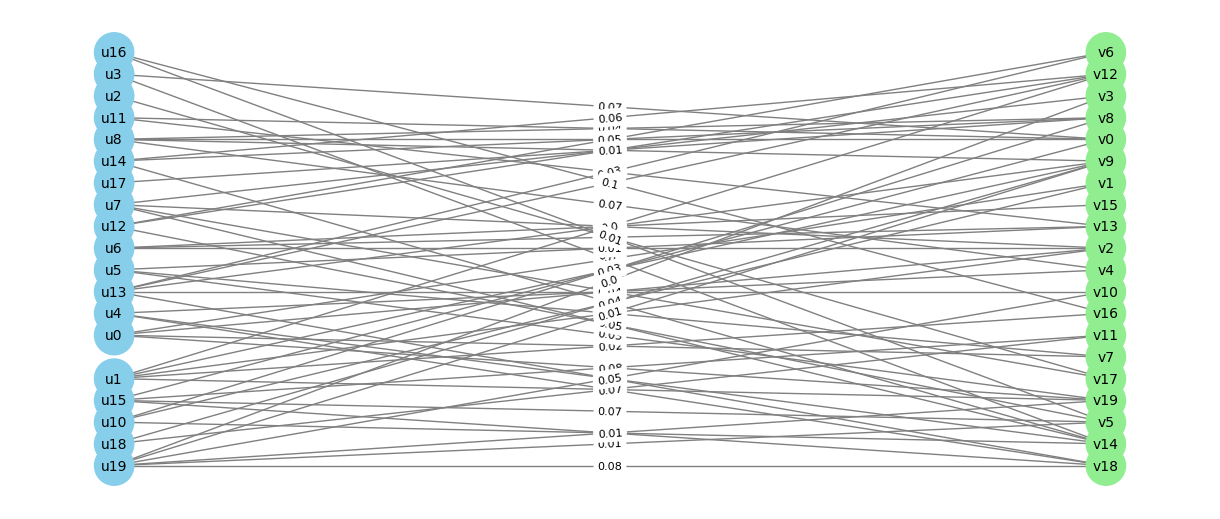

In [61]:
n_U, n_V = 20, 20

B, edges = generate_bipartite_erdos_graph(n_U, n_V, p_erd=np.log(n_U)/n_U, p_max=0.1)

U = [f"u{i}" for i in range(n_U)]
V = [f"v{j}" for j in range(n_V)]

plot_bipartite_graph(B, U, V, save_fig='./figs/graph_example.pdf')

In [118]:
def simple_model(v, edges, set_u=None):
    return max(edges, key=lambda e: e[2])[1] if edges else None


evaluator = OnlineMatchingEvaluator(simple_model, B, edges)
evaluator.run()

20

In [119]:
# OPT pour ce modèle:
evaluator.opt

1.3900000000005044

In [120]:
from src.nonadaptive import NonAdaptive

In [121]:
algo = NonAdaptive(edges)

evaluator = OnlineMatchingEvaluator(algo, B, edges)
evaluator.run()

0

In [127]:
from src.stochasticbalance import StochasticBalance
from src.semiadaptative import SemiAdaptative
from src.baseline import Baseline

In [128]:
algo = StochasticBalance(edges)

evaluator = OnlineMatchingEvaluator(algo, B, edges)
score = []
for _ in range(50):
    score.append(evaluator.run())

sum(score)/len(score)

0.34

In [129]:
evaluator.opt

1.3900000000005044

In [132]:
from src.benchmark import eval_benchmark

opt = {"algos": [Baseline, NonAdaptive, StochasticBalance, SemiAdaptative], # List des fonction de chaque algo
       "names": ['Naive', 'NonAdaptive', 'StochasticBalance', 'SemiAdaptative'],
       "p_values": ["random", 0.5, 0.1, 0.05], # Not the classical p values...
       "U_n": [20, 50, 150],
       "p_erd": [0.2, "n", "logn/n"],
       "k": 20,
       "p_max":0.1 # Proba max dans un edge dans le cas random
      }

results = eval_benchmark(opt)

100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


In [133]:
from src.utils import results_to_df

df_results = results_to_df(results)
df_results.round(2)

Naive  NonAdaptive  StochasticBalance  SemiAdaptative
p_value U_n p_erd                                                        
random  20  0.2      0.35         0.41               0.47            0.47
            n        0.49         0.49               0.33            0.49
            logn/n   0.38         0.49               0.38            0.45
        50  0.2      0.31         0.47               0.53            0.48
            n        0.49         0.51               0.49            0.37
            logn/n   0.33         0.45               0.49            0.45
        150 0.2      0.28         0.45               0.51            0.44
            n        0.50         0.51               0.45            0.51
            logn/n   0.32         0.46               0.56            0.43
0.5     20  0.2      0.05         0.11               0.11            0.11
            n        0.07         0.11               0.11            0.11
            logn/n   0.04         0.10               0.10            0.10
        50  0.2      0.03         0.10               0.10            0.10
            n        0.08         0.09               0.09            0.09
            logn/n   0.04         0.10               0.10            0.10
        150 0.2      0.01         0.10               0.10            0.10
            n        0.08         0.10               0.10            0.09
            logn/n   0.04         0.10               0.10            0.10
0.1     20  0.2      0.20         0.50               0.50            0.42
            n        0.25         0.37               0.50            0.46
            logn/n   0.26         0.42               0.47            0.45
        50  0.2      0.13         0.42               0.50            0.41
            n        0.33         0.35               0.37            0.36
            logn/n   0.23         0.46               0.47            0.47
        150 0.2      0.05         0.45               0.50            0.43
            n        0.35         0.42               0.41            0.40
            logn/n   0.21         0.44               0.50            0.42
0.05    20  0.2      0.25         0.65               0.65            0.55
            n        0.45         0.91               0.82            0.82
            logn/n   0.37         0.58               0.74            0.58
        50  0.2      0.24         0.62               0.88            0.62
            n        0.61         0.67               0.67            0.44
            logn/n   0.33         0.65               0.73            0.61
        150 0.2      0.10         0.67               1.00            0.68
            n        0.51         0.62               0.68            0.69
            logn/n   0.36         0.66               0.86            0.60

In [131]:
df_results.round(2).to_latex('./figs/results.tex')

/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_40811/2769141091.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_results.round(2).to_latex('./figs/results.tex')
